<a href="https://colab.research.google.com/github/markustoivonen/AIHealthTech2020/blob/master/exercises/ex7_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
"""
ELEC- E8739 AI in Health Technologies D. Exercise 7
Code by Joel Jaskari, Aalto University, 2020
"""

def get_horses_zebras_dataset(batch_size = 32):
    # A quick and dirty way to make a supervised dataset from the cyclegan horses and zebras dataset:
    # A = 0 = Horses
    # B = 1 = Zebras
    # These images will be 256x256 so keep that in mind
    dataset = tfds.as_numpy(tfds.load('cycle_gan/horse2zebra',
                                    as_supervised=True,
                                    batch_size=-1))

    train_horses_images,train_horses_labels = dataset['trainA']
    train_zebras_images,train_zebras_labels = dataset['trainB']
    test_horses_images,test_horses_labels = dataset['testA']
    test_zebras_images,test_zebras_labels = dataset['testB']

    # Make numpy arrays:
    train_images = np.concatenate([train_horses_images,train_zebras_images],axis=0)
    train_labels = np.concatenate([train_horses_labels,train_zebras_labels],axis=0)
    test_images = np.concatenate([test_horses_images,test_zebras_images],axis=0)
    test_labels = np.concatenate([test_horses_labels,test_zebras_labels],axis=0)
    # Split a validation set randomly from the train images. Lets say 20% of train set is enough:
    rng = np.random.RandomState(123)
    num_train_ims = train_images.shape[0]
    new_order_train = rng.permutation(num_train_ims)
    train_images = train_images[new_order_train]
    train_labels = train_labels[new_order_train]

    validation_images = train_images[0:int(num_train_ims*0.2)]
    validation_labels = train_labels[0:int(num_train_ims*0.2)]
    train_images = train_images[int(num_train_ims*0.2):]
    train_labels = train_labels[int(num_train_ims*0.2):]

    # Now we have the three sets: train, validation and test
    # Lastly we can make these into tensorflow datasets:
    # Notice that the Dataset.from_tensor_slices takes an array in, in this case two as tuple so that labels and images are in same order
    # then .batch(batch_size) will set the iterator such that it returns batch_size number of elements at once
    # IMPORTANT! typically we want to shuffle the data between epochs so that no periodicity in the order of the samples appears,
    # but tensorflow does not support this for huge datasets using tf.data API. You might want to change this if you have larger dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_labels)).shuffle(9999).batch(batch_size)
    validation_dataset = tf.data.Dataset.from_tensor_slices((validation_images,validation_labels)).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images,test_labels)).batch(batch_size)

    return train_dataset,validation_dataset,test_dataset


In [4]:
train_dataset, validation_dataset, test_dataset = get_horses_zebras_dataset()

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompletePRVSWE/cycle_gan-trainA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompletePRVSWE/cycle_gan-trainB.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompletePRVSWE/cycle_gan-testA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompletePRVSWE/cycle_gan-testB.tfrecord


Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0. Subsequent calls will reuse this data.


In [5]:
print(train_dataset)

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.uint8, tf.int64)>


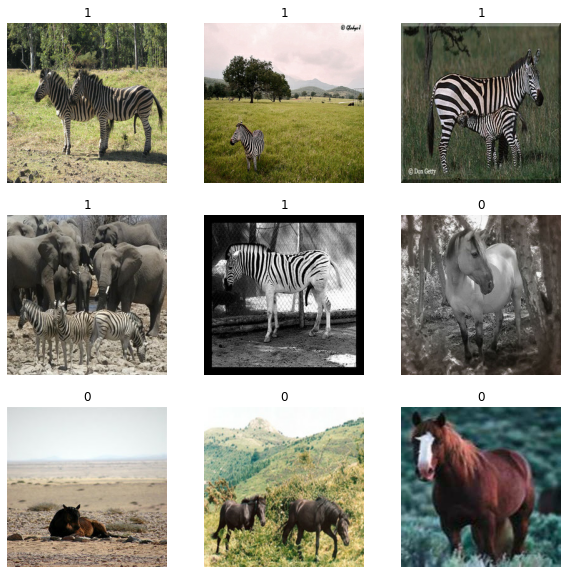

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")


In [7]:
base_model = tf.keras.applications.EfficientNetB0(input_shape=(256, 256, 3), include_top=False)
base_model.trainable = False
base_model.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 256, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization[0][0]              
____________________

In [8]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 8, 8, 1280)


In [9]:
model = keras.Sequential([base_model, layers.Flatten(), layers.Dense(2, name="class_score")])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 8, 8, 1280)        4049571   
_________________________________________________________________
flatten (Flatten)            (None, 81920)             0         
_________________________________________________________________
class_score (Dense)          (None, 2)                 163842    
Total params: 4,213,413
Trainable params: 163,842
Non-trainable params: 4,049,571
_________________________________________________________________


In [10]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


In [11]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)


15/15 [==============================] - 1s 66ms/step - loss: 7.1616 - accuracy: 0.3229


In [12]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


initial loss: 7.16
initial accuracy: 0.32


In [14]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,patience=3,restore_best_weights=True)
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=test_dataset,
                    callbacks=[callback])


Epoch 1/10
61/61 [==============================] - 5s 83ms/step - loss: 0.0723 - accuracy: 0.7418 - val_loss: 0.1790 - val_accuracy: 0.8192
Epoch 2/10
61/61 [==============================] - 5s 81ms/step - loss: 0.0652 - accuracy: 0.7533 - val_loss: 0.1790 - val_accuracy: 0.7769
Epoch 3/10
61/61 [==============================] - 5s 81ms/step - loss: 0.0738 - accuracy: 0.7975 - val_loss: 0.2083 - val_accuracy: 0.8269
Epoch 4/10
61/61 [==============================] - 5s 83ms/step - loss: 0.0607 - accuracy: 0.8371 - val_loss: 0.2112 - val_accuracy: 0.8692


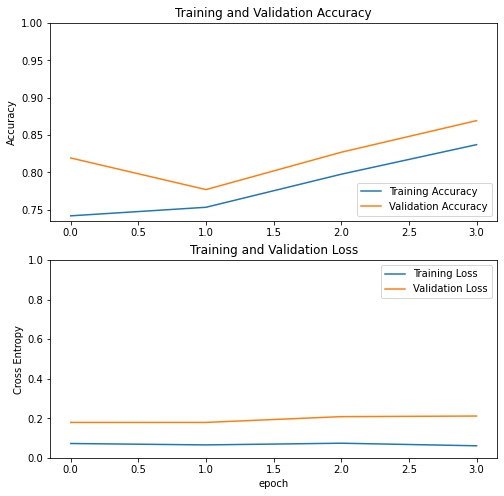

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [21]:
base_model = tf.keras.applications.EfficientNetB0(input_shape=(256, 256, 3), include_top=False, weights = None)
model = keras.Sequential([base_model, layers.Flatten(), layers.Dense(2, name="class_score")])
#model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 8, 8, 1280)        4049571   
_________________________________________________________________
flatten_2 (Flatten)          (None, 81920)             0         
_________________________________________________________________
class_score (Dense)          (None, 2)                 163842    
Total params: 4,213,413
Trainable params: 4,171,390
Non-trainable params: 42,023
_________________________________________________________________


In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [18]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,patience=3,restore_best_weights=True)
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=test_dataset,
                    callbacks=[callback])

Epoch 1/10
 2/61 [..............................] - ETA: 10s - loss: 2.8750 - accuracy: 0.6250WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1057s vs `on_train_batch_end` time: 0.2579s). Check your callbacks.


61/61 [==============================] - 24s 399ms/step - loss: 2.3046 - accuracy: 0.3868 - val_loss: 4.7471 - val_accuracy: 0.5385
Epoch 2/10
61/61 [==============================] - 23s 383ms/step - loss: 1.5609 - accuracy: 0.3493 - val_loss: 4.8910 - val_accuracy: 0.4615
Epoch 3/10
61/61 [==============================] - 23s 384ms/step - loss: 2.7849 - accuracy: 0.5908 - val_loss: 8.3057 - val_accuracy: 0.4615
Epoch 4/10
61/61 [==============================] - 23s 383ms/step - loss: 2.4445 - accuracy: 0.6705 - val_loss: 4.5954 - val_accuracy: 0.4615
Epoch 5/10
61/61 [==============================] - 23s 382ms/step - loss: 2.0854 - accuracy: 0.7340 - val_loss: 4.5801 - val_accuracy: 0.4615
Epoch 6/10
61/61 [==============================] - 23s 384ms/step - loss: 2.7533 - accuracy: 0.5960 - val_loss: 8.3057 - val_accuracy: 0.5385
Epoch 7/10
61/61 [==============================] - 23s 383ms/step - loss: 4.7194 - accuracy: 0.3649 - val_loss: 3.8630 - val_accuracy: 0.5385
Epoch 8/10

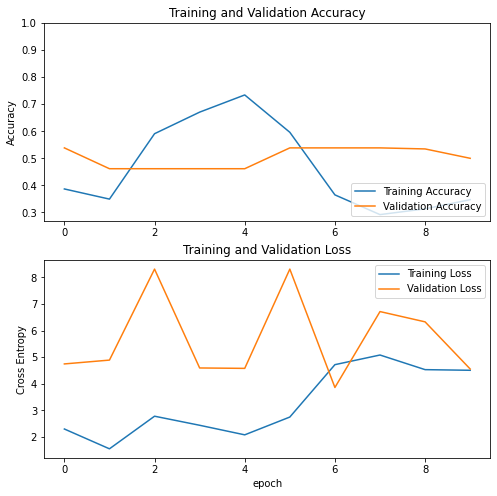

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
